# Cleaning the Data

### Row Headings
"Vehicle Make" = brand, "Violation County" = borough

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csv_filename = 'Parking_Violations_Issued_-_Fiscal_Year_2017.csv'
df = pd.read_csv(csv_filename)
df = df.sample(3000)

/var/folders/24/1_dt0kg92db1tm0fvthfm71w0000gn/T/ipykernel_26400/703739519.py:2: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_filename)


In [3]:

# csv_filename = 'Parking_Violations_Issued_-_Fiscal_Year_2017_sample.csv'

# This field holds a list of all the columns that we are exploring
features = ['Plate ID', 'Issue Date', 'Violation Time', 'Issue Datetime', 'Vehicle Make', 'Vehicle Body Type', 'Violation County', 'Street Name', 'Violation Code', 'Violation Description']

# df = pd.read_csv(csv_filename)
# df = df.sample(3000)

# Clean data of all null issue dates and typos in violation time
def verify_valid_violation_time(entry):
    return len(entry) == 5 and entry[0:4].isdecimal() and int(entry[0:2]) <= 12 and int(entry[2:4]) < 60 and (entry[4] == 'P' or entry[4] == 'A')
df = df[df['Issue Date'].notnull()]
df = df[df['Violation Time'].notnull()]
df = df[df['Violation Time'].apply(lambda x: verify_valid_violation_time(x))]

# Combine Issue Date and violation time to gather accurate time of each violation
def format_date(date):
    if date[0:2] == '00':
        date = date.replace('00', '12')
    return f'{date[0:2]}:{date[2:]}M'
df['Violation Time'] = df['Violation Time'].apply(lambda x: format_date(x))
df['Issue Datetime'] = pd.to_datetime(df['Issue Date'] + ' ' + df['Violation Time'])
df['Issue Date'] = pd.to_datetime(df['Issue Date'])

# Remove all null values in the fields we are exploring
for feature in features:
    df = df[df[feature].notnull()]

# Remove Typo's in Street Name (the csv appears to sometimes have part of the intersecting street leak onto to street name)
# Typo's fixed by truncating after @ sign
df['Street Name'] = df['Street Name'].apply(lambda x: x.split('@')[0])

# Standardize ways of describing borough names, and remove typos
# Note: R appears to be Staten island bc it's Richmond County
# After Rename: BX = Bronx, BK = Brooklyn, QN = Queens, MN = Manhattan, ST = Staten Island
boroughs = {'BX': 'BX', 'BK': 'BK', 'QN': 'QN', 'NY': 'MN', 'Q': 'QN', 'K': 'BK', 'ST': 'ST', 'MN': 'MN', 'R': 'ST', 'BRONX': 'BX', 'QNS': 'QN', 'KINGS': 'BK'}
df['Violation County'] = df['Violation County'].apply(lambda x: boroughs.get(x, None))
df = df[df[feature].notnull()]


# Standardize Formatting of Violation Descriptions
df['Violation Description'] = df['Violation Description'].apply(lambda x: x.upper())
df['Violation Description Includes Code'] = df['Violation Description'].apply(lambda x: x[0].isdecimal())
# df['Violation Description'] = (df['Violation Code'].astype(str) + df['Violation Description']).where(df['Violation Description Includes Code'])
df['Violation Description'] = np.where(df['Violation Description Includes Code'],
                                       df['Violation Description'],
                                       df['Violation Code'].astype(str) + '-' + df['Violation Description'])
# display('df violation description', df['Violation Description Includes Code'])
# Picking only features we are interested in
df = df[features]
df.dtypes

Plate ID                         object
Issue Date               datetime64[ns]
Violation Time                   object
Issue Datetime           datetime64[ns]
Vehicle Make                     object
Vehicle Body Type                object
Violation County                 object
Street Name                      object
Violation Code                    int64
Violation Description            object
dtype: object

In [4]:
df.sort_values(by='Issue Datetime')

,Plate ID,Issue Date,Violation Time,Issue Datetime,Vehicle Make,Vehicle Body Type,Violation County,Street Name,Violation Code,Violation Description
10547571,GST7792,2016-05-31,09:30AM,2016-05-31 09:30:00,NISSA,4DSD,BX,GRAND CONCOURSE (S/B,7,7-FAILURE TO STOP AT RED LIGHT
10550658,HCP2199,2016-06-01,07:44AM,2016-06-01 07:44:00,TOYOT,4DSD,QN,WB HILLSIDE AVE,5,5-BUS LANE VIOLATION
10559133,FSV2981,2016-06-06,12:46PM,2016-06-06 12:46:00,CHEVR,SUBN,ST,MILFORD DR (E/B),7,7-FAILURE TO STOP AT RED LIGHT
10567317,HAX7229,2016-06-09,09:02AM,2016-06-09 09:02:00,JEEP,SUBN,QN,NORTHERN BLVD (E/B),7,7-FAILURE TO STOP AT RED LIGHT
10568556,BXJ3111,2016-06-10,01:03PM,2016-06-10 13:03:00,HONDA,SUBN,BX,GRAND CONCOURSE (N/B,7,7-FAILURE TO STOP AT RED LIGHT
...,...,...,...,...,...,...,...,...,...,...
5637181,88109,2017-06-27,12:04PM,2017-06-27 12:04:00,BMW,SUBN,BX,NB WATER PL. WESTCHS,36,36-PHTO SCHOOL ZN SPEED VIOLATION
2660963,XCYV13,2017-06-27,01:24PM,2017-06-27 13:24:00,FORD,VAN,MN,Columbia St,20,20-NO PARKING (COM PLATE)
6224014,CZG7353,2017-06-27,01:55PM,2017-06-27 13:55:00,FORD,4DSD,BK,17th Ave,70,70-REG. STICKER MISSING (NYS)
2268527,HNF6277,2017-06-27,02:24PM,2017-06-27 14:24:00,HONDA,4DSD,MN,E 11th St,16,16A-NO STD (COM VEH) NON-COM


In [5]:


# Find number of 
# display(df['Violation County'].value_counts())
# df = df[['Violation County']]
# df.describe()
df.head()

,Plate ID,Issue Date,Violation Time,Issue Datetime,Vehicle Make,Vehicle Body Type,Violation County,Street Name,Violation Code,Violation Description
2599646,HLN3227,2017-01-29,05:08AM,2017-01-29 05:08:00,HONDA,4DSD,BX,Morris Ave,40,40-FIRE HYDRANT
4794195,EHD9074,2017-01-05,01:07PM,2017-01-05 13:07:00,LINCO,4DSD,BX,SB BAYCHESTER AVE,36,36-PHTO SCHOOL ZN SPEED VIOLATION
9919151,ETS1379,2017-06-02,10:36AM,2017-06-02 10:36:00,LINCO,SUBN,MN,W 128th St,51,51-SIDEWALK
10688012,BMH3626,2016-06-27,03:46PM,2016-06-27 15:46:00,AUDI,4DSD,BX,NB BAYCHESTER AVE,36,36-PHTO SCHOOL ZN SPEED VIOLATION
3272760,GPE3288,2016-10-14,08:50PM,2016-10-14 20:50:00,ME/BE,4DSD,BK,Lenox Rd,20,20A-NO PARKING (NON-COM)


In [6]:
# Exploratory Data Analysis
# Five EDA Steps: 
# - Variance/Standard Dev/Mean/Mode/Median/ 
# - Scatter Plot - times of violation
# - line/Bar graph - boroughs where each violation committed
# - pie chart - 1. which Make makes the most violation 2. Whats the common type of Violations
# - Histogram - Months of Violation

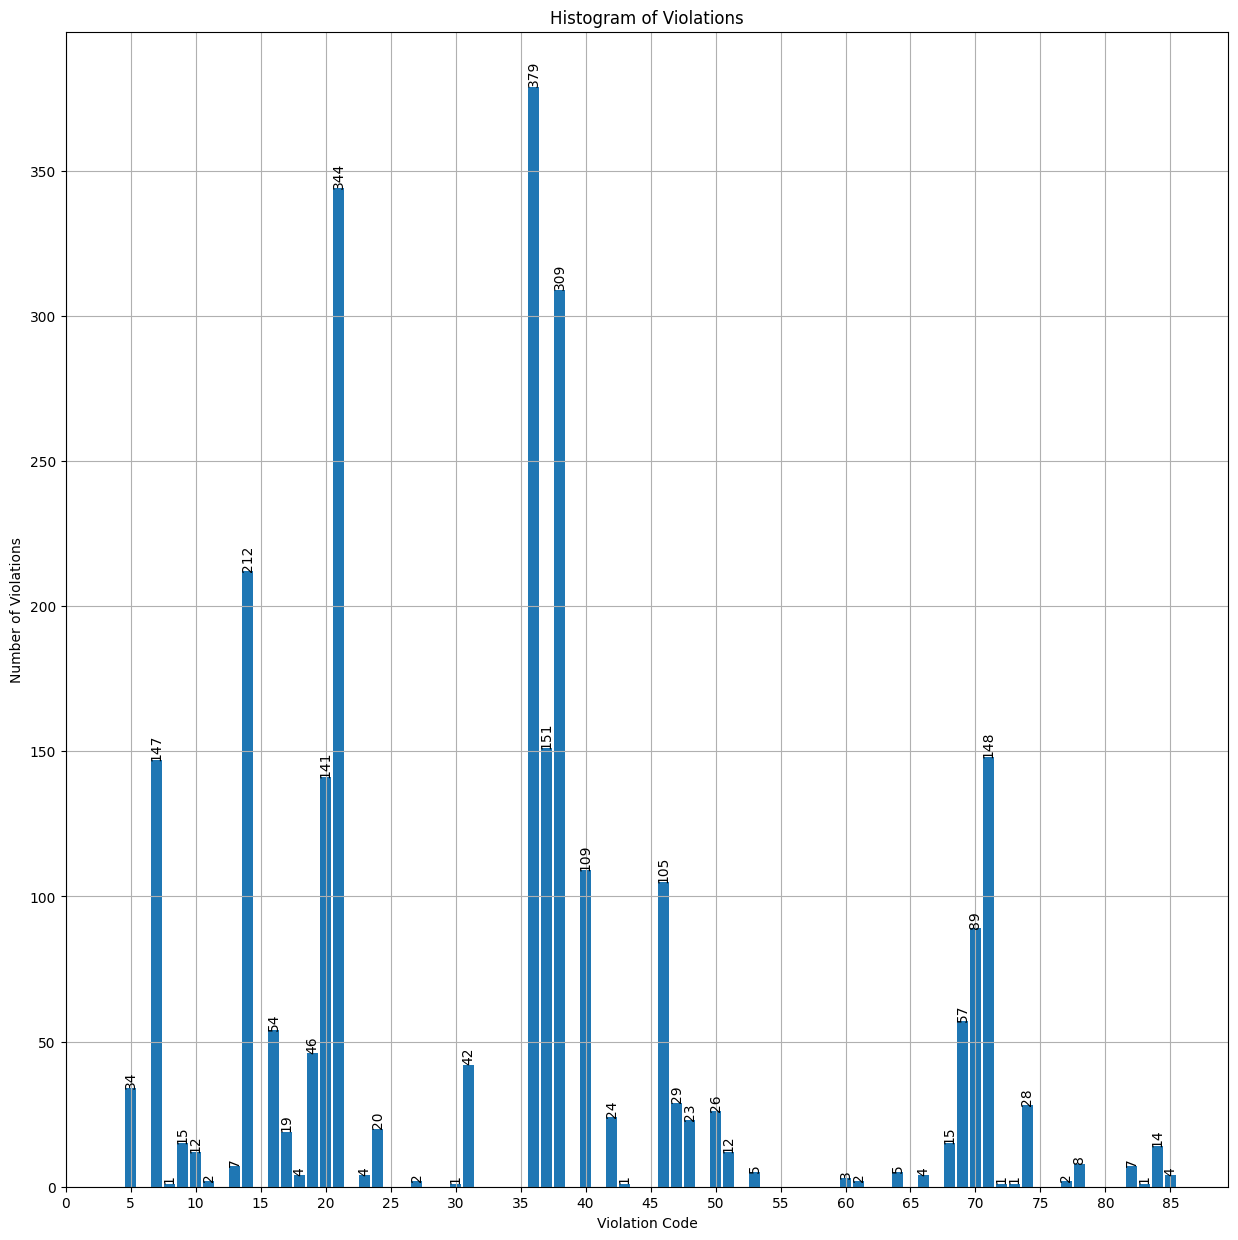

In [59]:
# Bar Graph for Number of Particular Violation Incurred
# plt.figure()
# plt.hist(df["Violation Code"])

# Count the occurrences of each violation code
violation_counts = df['Violation Code'].value_counts().sort_index()

plt.figure(figsize=(15, 15))

bars = plt.bar(violation_counts.index, violation_counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, int(height), ha='center', va='bottom', rotation=90)

#plotting
plt.title('Histogram of Violations')
plt.xlabel('Violation Code')
plt.ylabel('Number of Violations')
plt.xticks(range(0, max(violation_counts.index) + 5, 5))
plt.grid(True)
plt.show()

# bar graph to find the most number of common violations in the NY boroughs
# We can see the Violation code 36, 21, and 38 are the most common occuring violations
# Violation Code Description
    # Code 36 - Exceeding the posted speed limit in or near a designated school zone
    # Code 21 - Street Cleaning: No parking where parking is not allowed by sign
    # Code 38 - Parking Metre; Failing to show a receipt or tag in the windshield
# We can infer various things from the violations but to further develop analysis we can split the data with more plots and graphs


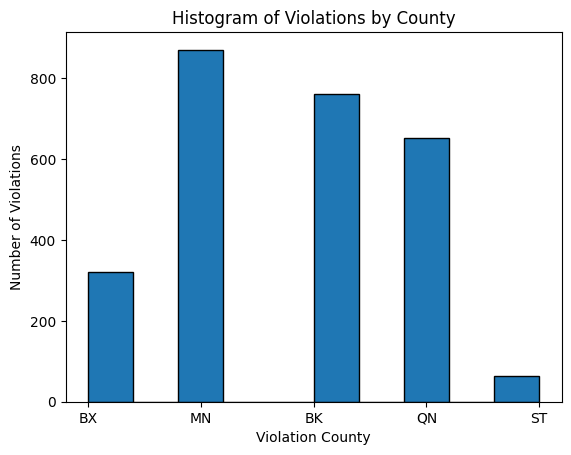

In [29]:
# graph boroughs where each violation committed

#plotting
plt.figure()
plt.hist(df['Violation County'],  edgecolor='black')

plt.title('Histogram of Violations by County')
plt.xlabel('Violation County')
plt.ylabel('Number of Violations')
plt.show()

# We used the Histogram to find the violation occured in all the boroughs.
# We can see Manhattan with the most number of violations.

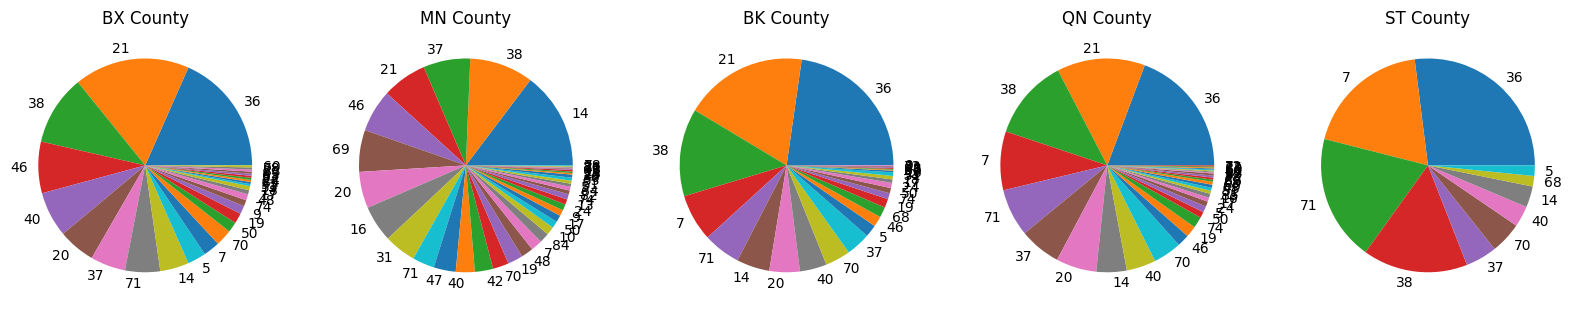

In [58]:
# Pie Charts to find the common violation in every borough


boroughs = df['Violation County'].unique()


fig, axes = plt.subplots(1, len(boroughs), figsize=(20, 15))

# loop generating multiple charts
for ax, county in zip(axes, boroughs):
    county_data = df[df['Violation County'] == county]

    violation_counts = county_data['Violation Code'].value_counts()
    
    ax.pie(violation_counts, labels=violation_counts.index)
    ax.set_title(f'{county} County')

#plotting
plt.show()

# The bar graphs show all the violations occured in the area county.
# we can see that the most common violation code is 36 and the common one across all borough except Manhattan
# Code 14 - General No Standing: Standing or parking where standing is not allowed by sign
# For Manhattan, we can see that the top 5 violations are space related. 14 being the standing in a no standing zone.
# 38 and 37 being Parking Metre violations, staying there for more time or not displaying the parking ticket
# 21 - Parked during street cleaning and 46 - Standing or parking on the roadway side of a vehicle stopped


In [51]:
# Scatter plot to find the frequency of violation based on the times in all counties
#*Need to update after the violation issue time*#


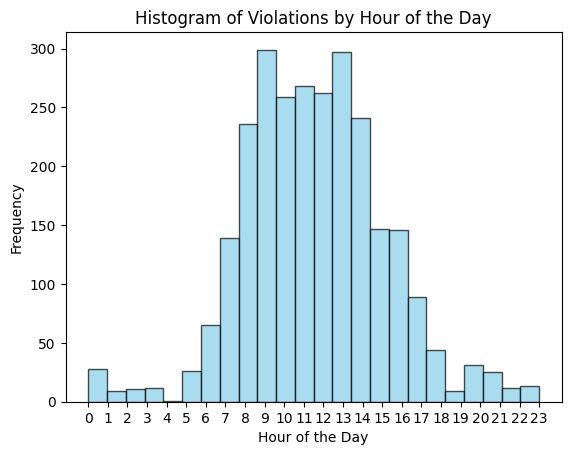

In [61]:
# using histogram for the violation on the time of the day

# creating new tables to change the format of the date time
df['Violation Time'] = pd.to_datetime(df['Violation Time'], format='%I:%M%p')
df['Hour'] = df['Violation Time'].dt.hour

#plotting
plt.figure()
plt.hist(df['Hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Violations by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))

plt.show()

# This histogram shows the data arranged based on the violation by the hour of the day
# We can see a bell curve in the data distribution where the peek time for any violation ins right around noon
# And there is a slight skew of data during the middle of the night and a dip early morning. 
# This could be for the time during when people are asleep.
# The highest peak indicates that there is a lot of traffic around all the boroughs where multiple violations are happening